# Stochastic Simulation of the Birth-Death Process
This notebook guides you through the simulation of a stochastic **birth-death process** using the Gillespie algorithm. You'll start from a complete core implementation, and then define and explore your own birth-death system.

The birth-death process has two reactions:
- **Birth**: $N \rightarrow N + 1$ at rate $\lambda N$
- **Death**:  $N \rightarrow N - 1$ at rate $\mu N$

You’ll write your own version of this process and compare the simulation results to the known analytical mean and variance.

---

## 🔧 Core Gillespie Simulation Code (DO NOT EDIT BELOW)


In [11]:

import numpy as np


def sample_event_time(propensities, rng=np.random.default_rng()):
    total_rate = sum(propensities)
    if total_rate == 0:
        return np.inf, None
    r1 = rng.uniform()
    tau = (1 / total_rate) * np.log(1 / r1)
    r2 = rng.uniform() * total_rate
    cumulative = 0.0
    for k, a in enumerate(propensities):
        cumulative += a
        if r2 <= cumulative:
            return tau, k
    return tau, len(propensities) - 1


def simulate_dynamic_process(initial_state, get_propensities, updates, t_max, rng=np.random.default_rng()):
    t = 0.0
    state = initial_state
    times = [t]
    states = [state]
    rates = get_propensities(state, t)
    while t < t_max:
        if sum(rates) == 0:
            break
        tau, event_idx = sample_event_time(rates, rng)
        if event_idx is None or np.isinf(tau):
            break
        t += tau
        if t > t_max:
            break
        state = updates[event_idx](state)
        times.append(t)
        states.append(state)
        rates = get_propensities(state, t)
    return np.array(times), np.array(states)


# ✏️ Step 1: Define Your Birth-Death Process

Fill in the following function to define a **birth-death process** where:

- Birth occurs at rate `λ * N`
- Death occurs at rate `μ * N`
- Make sure to prevent negative population sizes


In [14]:
# ✅ SOLUTION: Birth-Death Process Definition
def get_birth_death_process(lambda_rate, mu_rate):
    """
    Returns modular components for a birth-death process.

    Parameters:
    - lambda_rate: birth rate coefficient
    - mu_rate: death rate coefficient

    Returns:
    - get_propensities: function(state, time) -> list of event rates
    - updates: list of functions to update state after each event
    """

    # Define individual propensities for birth and death
    prop_list = [
        lambda N: lambda_rate * N,  # Birth: rate λN
        lambda N: mu_rate * N       # Death: rate μN
    ]

    # Wrap propensities into a unified function for the simulation interface
    def get_propensities(N, t):
        return [f(N) for f in prop_list]

    # Define state updates for birth and death
    updates = [
        lambda N: N + 1,             # Birth: N → N + 1
        lambda N: max(N - 1, 0)      # Death: N → N - 1 (no negative states)
    ]

    return get_propensities, updates


# ▶️ Step 2: Simulate and Plot a Birth-Death Trajectory

Use your function from Step 1 to simulate a single trajectory of the birth-death process.
Try changing parameters like `lambda_rate`, `mu_rate`, and `N0` to observe different behaviors.


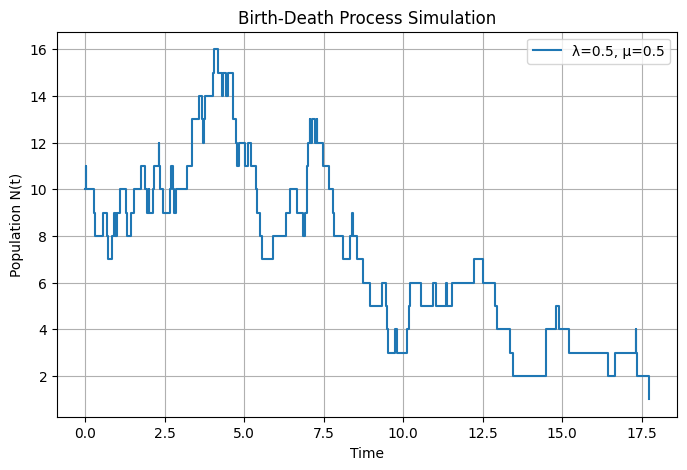

In [18]:
import matplotlib.pyplot as plt

def run_and_plot_birth_death(N0=10, lambda_rate=1.0, mu_rate=0.5, t_max=20.0, seed=42):
    rng = np.random.default_rng(seed)
    get_propensities, updates = get_birth_death_process(lambda_rate, mu_rate)
    times, states = simulate_dynamic_process(N0, get_propensities, updates, t_max, rng)

    plt.figure(figsize=(8, 5))
    plt.step(times, states, where='post', label=f"λ={lambda_rate}, μ={mu_rate}")
    plt.xlabel("Time")
    plt.ylabel("Population N(t)")
    plt.title("Birth-Death Process Simulation")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example call (edit these parameters)
run_and_plot_birth_death(N0=10, lambda_rate=0.5, mu_rate=0.5, t_max=20.0)


# 📊 Step 3: Compare to Analytical Mean and Variance

For the **birth-death process**, the expected number of individuals at time \( t \), starting from \( N_0 \), follows:

$$
\mathbb{E}[N(t)] = N_0 \cdot e^{(\lambda - \mu)t}
$$

If $\lambda \neq \mu$, the variance is:

$$
\text{Var}[N(t)] = N_0 \cdot \frac{\lambda + \mu}{\lambda - \mu} \left( e^{(\lambda - \mu)t} \cdot \left(e^{(\lambda - \mu)t} - 1\right) \right)
$$

In the **critical case** $\lambda = \mu$, the mean stays constant and the variance grows linearly:

$$
\mathbb{E}[N(t)] = N_0, \quad \text{Var}[N(t)] = 2 N_0 \lambda t
$$

---

Run many stochastic trajectories below and compare the empirical mean and variance to these predictions.

> **Challenge**: What happens when $\lambda < \mu$? Can the population go extinct? What does the variance do over time?


In [36]:
def plot_birth_death_trajectories_vs_analytics(
    N0=10,
    lambda_rate=1.0,
    mu_rate=0.5,
    t_max=20.0,
    n_runs=50,
    seed=42,
    draw_fill=True,
    line_alpha=0.3,
    analytic_resolution=150,
    y_range=None  # new argument to control y-axis range
):
    rng = np.random.default_rng(seed)

    # Prepare process components once
    get_propensities, updates = get_birth_death_process(lambda_rate, mu_rate)

    # Precompute analytical curves
    t_vals = np.linspace(0, t_max, analytic_resolution)
    delta = lambda_rate - mu_rate
    analytic_mean = N0 * np.exp(delta * t_vals)

    if delta != 0:
        analytic_var = N0 * (lambda_rate + mu_rate) / delta * (
            np.exp(delta * t_vals) * (np.exp(delta * t_vals) - 1)
        )
    else:
        analytic_var = 2 * N0 * lambda_rate * t_vals  # Critical case

    # Plot setup
    fig, ax = plt.subplots(figsize=(9, 5))

    # Simulated trajectories
    for _ in range(n_runs):
        times, states = simulate_dynamic_process(N0, get_propensities, updates, t_max, rng)
        ax.step(times, states, where='post', alpha=line_alpha, color='gray')

    # Overlay analytical curves
    ax.plot(t_vals, analytic_mean, '--', color='blue', label="Analytical Mean")

    if draw_fill:
        ax.fill_between(
            t_vals,
            analytic_mean - np.sqrt(analytic_var),
            analytic_mean + np.sqrt(analytic_var),
            color="blue",
            alpha=0.15,
            label="Analytical ±1 std"
        )

    # Set axis labels and optional y-limits
    ax.set_xlabel("Time")
    ax.set_ylabel("Population N(t)")
    ax.set_title(f"Birth-Death Process: {n_runs} Trajectories vs Theory")
    if y_range is not None:
        ax.set_ylim(*y_range)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

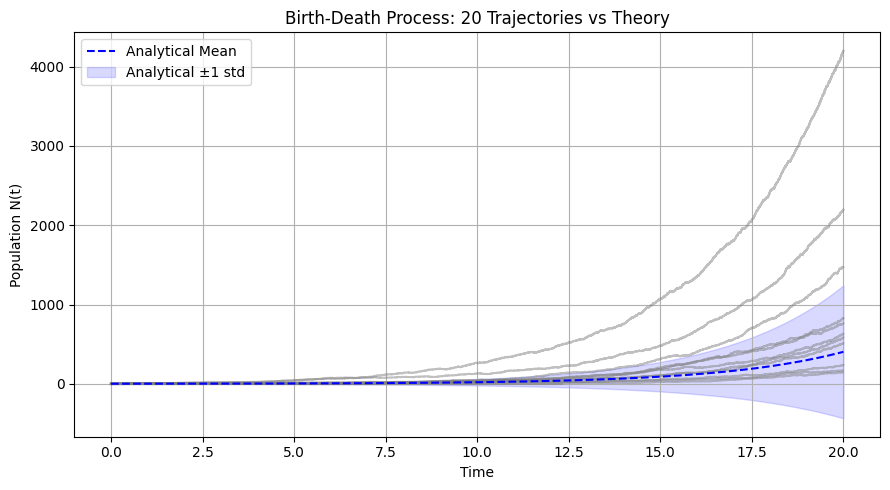

In [63]:
# Here we can play around a little:
plot_birth_death_trajectories_vs_analytics(
    N0=1,
    lambda_rate=0.8,
    mu_rate=0.5,
    t_max=20.0,
    n_runs=20,
    draw_fill=True,
    line_alpha=0.5,
    y_range= None  # constrain y-axis
)

# 📉 Extinction Events

In stochastic systems with **birth and death**, extinction occurs when the population reaches zero and stays there.

Even if the expected value (mean) grows, **stochastic fluctuations** can cause extinction in some trajectories — especially when \( \lambda \leq \mu \).

In this section, we:
- Track **extinction events** across multiple runs
- Plot a **raster of extinction times**
- (Optional) Visualize the **distribution of extinction times**

This helps us see how often extinction happens, and when.

---


In [69]:
# Track extinction times over many trajectories

def plot_extinction_raster(
    N0=10,
    lambda_rate=0.5,
    mu_rate=0.6,
    t_max=20.0,
    n_runs=100,
    seed=42,
    show_hist=False
):
    rng = np.random.default_rng(seed)
    get_propensities, updates = get_birth_death_process(lambda_rate, mu_rate)

    extinction_times = []

    for _ in range(n_runs):
        times, states = simulate_dynamic_process(N0, get_propensities, updates, t_max, rng)
        if states[-1] == 0:
            extinction_times.append(times[-1])

    # Raster plot of extinction times
    plt.figure(figsize=(8, 2))
    plt.eventplot(extinction_times, orientation='horizontal', color='red', lineoffsets=0.5)
    plt.title("Extinction Times (Raster Plot)")
    plt.xlabel("Time")
    plt.yticks([])
    plt.grid(True)
    plt.show()

    if show_hist:
        plt.figure(figsize=(8, 4))
        plt.hist(extinction_times, bins=20, color='red', alpha=0.6)
        plt.title("Histogram of Extinction Times")
        plt.xlabel("Time of Extinction")
        plt.ylabel("Number of Trajectories")
        plt.grid(True)
        plt.show()

    print(f"Extinction occurred in {len(extinction_times)} out of {n_runs} runs "
          f"({100 * len(extinction_times) / n_runs:.1f}%)")

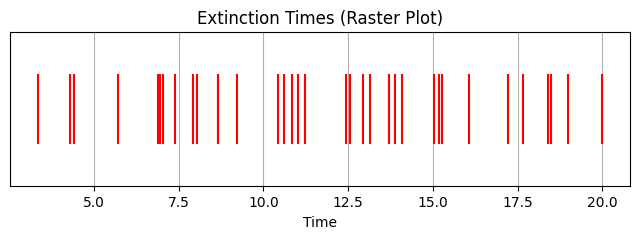

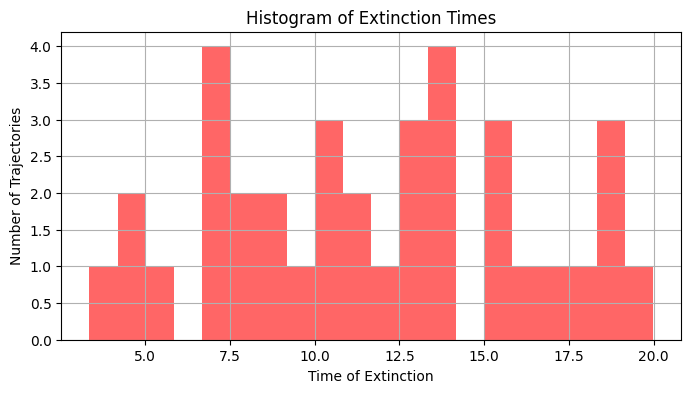

Extinction occurred in 36 out of 100 runs (36.0%)


In [70]:
# Example usage
plot_extinction_raster(
    N0=10,
    lambda_rate=0.5,
    mu_rate=0.5,
    t_max=20.0,
    n_runs=100,
    show_hist=True
)
